In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

In [2]:
BASE_DIR = ''
#COUNTRY = 'malawi_2016'
RANDOM_SEED = 7
#COUNTRY_DIR = os.path.join(BASE_DIR, 'countries', COUNTRY)
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODEL_DIR = os.path.join(DATA_DIR, 'models')

# these relate to the current country in question
IMAGE_DIR = os.path.join('PH_IMAGES_DIR')
RESULTS_DIR = os.path.join(DATA_DIR, 'results')
CNN_SAVE_FEATS_DIR = os.path.join(RESULTS_DIR, 'cnn')

In [3]:
PROCESSED_DIR = DATA_DIR

In [4]:
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(CNN_SAVE_FEATS_DIR, exist_ok=True)

# Feature extract with CNN
If you have run this step before, you can skip it and run the commented out code in the next section to quick-start.

In [90]:
df_images = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'))

In [91]:
df_images.head()

,Unnamed: 0,lon,lat,emission,filename,nightlights,nightlights_bin,imgrenamed,is_train
0,0,121.087500,18.612500,7.467103,18.6125_121.0875.jpg,0.051440,1,18.6125_121.0875_18.6125_121.0875.jpg,False
1,1,120.779167,18.604167,6.376585,18.604166666666664_120.77916666666668.jpg,0.030283,0,18.604166666666664_120.77916666666668_18.60416...,True
2,2,121.054167,18.604167,7.586672,18.604166666666664_121.05416666666667.jpg,0.050283,1,18.604166666666664_121.05416666666667_18.60416...,True
3,3,121.062500,18.604167,8.018453,18.604166666666664_121.0625.jpg,0.050607,1,18.604166666666664_121.0625_18.604166666666664...,True
4,4,121.070833,18.604167,7.548463,18.604166666666664_121.07083333333334.jpg,0.051067,1,18.604166666666664_121.07083333333334_18.60416...,True


In [92]:
#df_images = pd.rename(columns = {'filename':'image_name'}, inplace = True) 

In [93]:
#df_images.head()

In [95]:
df_sampled = df_images.sample(n = 5000)
df_sampled

,Unnamed: 0,lon,lat,emission,filename,nightlights,nightlights_bin,imgrenamed,is_train
74883,74883,121.987500,7.020833,7.346777,7.020833333333332_121.9875.jpg,0.106715,1,7.020833333333332_121.9875_7.020833333333332_1...,True
24661,24661,121.237500,14.154167,31.737068,14.154166666666663_121.2375.jpg,0.252790,1,14.154166666666663_121.2375_14.154166666666663...,True
16733,16733,121.137500,14.937500,9.005514,14.9375_121.1375.jpg,0.150688,1,14.9375_121.1375_14.9375_121.1375.jpg,True
13960,13960,120.995833,15.187500,11.922203,15.1875_120.99583333333334.jpg,0.345881,1,15.1875_120.99583333333334_15.1875_120.9958333...,False
43138,43138,122.487500,10.954167,15.187046,10.954166666666666_122.4875.jpg,0.051304,1,10.954166666666666_122.4875_10.954166666666666...,True
...,...,...,...,...,...,...,...,...,...
52524,52524,122.970833,10.154167,17.055782,10.154166666666663_122.97083333333332.jpg,0.053027,1,10.154166666666663_122.97083333333332_10.15416...,True
44714,44714,122.554167,10.854167,12.203071,10.854166666666664_122.55416666666667.jpg,0.157289,1,10.854166666666664_122.55416666666667_10.85416...,False
45683,45683,123.387500,10.795833,22.309916,10.795833333333333_123.3875.jpg,0.066776,1,10.795833333333333_123.3875_10.795833333333333...,True
67715,67715,123.804167,7.954167,7.427382,7.954166666666667_123.80416666666667.jpg,0.030656,0,7.954166666666667_123.80416666666667_7.9541666...,True


In [96]:
df_sampled['is_train'].value_counts()

True     4260
False     740
Name: is_train, dtype: int64

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} as backend')
model = torch.load(os.path.join(MODEL_DIR, 'trained_model.pt'), map_location=device)

Using cpu as backend


In [98]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

In [99]:
# rip off the final layers
model.classifier = model.classifier[:4]

In [100]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

In [101]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# custom dataset for fast image loading and processing
class ForwardPassDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transformer):
        self.image_dir = image_dir
        self.image_list = os.listdir(self.image_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_name = self.image_list[index]

        # Load image
        X = self.filename_to_im_tensor(self.image_dir + '/' + image_name)
        
        # dataloaders need to return a label, but for the forward pass we don't really care
        return X, -1
    
    def filename_to_im_tensor(self, file):
        im = plt.imread(file)[:,:,:3]
        im = self.transformer(im)
        return im

dataset = ForwardPassDataset(IMAGE_DIR, transformer)
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)
image_order = dataset.image_list

In [102]:
unique_ims = pd.DataFrame.from_dict({'image_name': image_order})
unique_ims.shape

(79946, 1)

In [103]:
feats = np.zeros((unique_ims.shape[0],4096))

## Forward Pass

In [18]:
model.eval()

i = 0
# Iterate over data.
for inputs, _ in tqdm(dataloader):
    inputs = inputs.to(device)
    outputs = model(inputs)
    feats[i:i+len(inputs),:] = outputs.cpu().detach().numpy()
    i += len(inputs)

  0%|          | 0/9994 [00:00<?, ?it/s]

C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\torchvision\transforms\functional.py:57: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


PermissionError: [Errno 13] Permission denied: 'PH_IMAGES_DIR/train'

In [104]:
np.save(os.path.join(CNN_SAVE_FEATS_DIR, 'forward_feats.npy'), feats)

In [105]:
unique_ims = unique_ims[['image_name']]
# this will be joined with the main df to show what index you should be looking at in feats
unique_ims['feat_index'] = np.arange(len(unique_ims))

In [106]:
#unique_ims.head()
unique_ims

,image_name,feat_index
0,10.004166666666666_122.7125.jpg,0
1,10.004166666666666_122.72083333333332.jpg,1
2,10.004166666666666_122.72916666666669.jpg,2
3,10.004166666666666_122.7375.jpg,3
4,10.004166666666666_122.74583333333334.jpg,4
...,...,...
79941,9.995833333333332_124.4375.jpg,79941
79942,9.995833333333332_124.44583333333334.jpg,79942
79943,9.995833333333332_124.45416666666668.jpg,79943
79944,train,79944


In [107]:
unique_ims.columns = ['filename', 'feat_index'] 

In [108]:
unique_ims.head()

,filename,feat_index
0,10.004166666666666_122.7125.jpg,0
1,10.004166666666666_122.72083333333332.jpg,1
2,10.004166666666666_122.72916666666669.jpg,2
3,10.004166666666666_122.7375.jpg,3
4,10.004166666666666_122.74583333333334.jpg,4


In [109]:
unique_ims.to_csv(r'data/feats_v1.csv', index = False)

In [110]:
df_sampled

,Unnamed: 0,lon,lat,emission,filename,nightlights,nightlights_bin,imgrenamed,is_train
74883,74883,121.987500,7.020833,7.346777,7.020833333333332_121.9875.jpg,0.106715,1,7.020833333333332_121.9875_7.020833333333332_1...,True
24661,24661,121.237500,14.154167,31.737068,14.154166666666663_121.2375.jpg,0.252790,1,14.154166666666663_121.2375_14.154166666666663...,True
16733,16733,121.137500,14.937500,9.005514,14.9375_121.1375.jpg,0.150688,1,14.9375_121.1375_14.9375_121.1375.jpg,True
13960,13960,120.995833,15.187500,11.922203,15.1875_120.99583333333334.jpg,0.345881,1,15.1875_120.99583333333334_15.1875_120.9958333...,False
43138,43138,122.487500,10.954167,15.187046,10.954166666666666_122.4875.jpg,0.051304,1,10.954166666666666_122.4875_10.954166666666666...,True
...,...,...,...,...,...,...,...,...,...
52524,52524,122.970833,10.154167,17.055782,10.154166666666663_122.97083333333332.jpg,0.053027,1,10.154166666666663_122.97083333333332_10.15416...,True
44714,44714,122.554167,10.854167,12.203071,10.854166666666664_122.55416666666667.jpg,0.157289,1,10.854166666666664_122.55416666666667_10.85416...,False
45683,45683,123.387500,10.795833,22.309916,10.795833333333333_123.3875.jpg,0.066776,1,10.795833333333333_123.3875_10.795833333333333...,True
67715,67715,123.804167,7.954167,7.427382,7.954166666666667_123.80416666666667.jpg,0.030656,0,7.954166666666667_123.80416666666667_7.9541666...,True


In [111]:
df_consumption = pd.merge(left=df_sampled, right=unique_ims, on='filename')

In [112]:
#df_consumption.head()
df_consumption

,Unnamed: 0,lon,lat,emission,filename,nightlights,nightlights_bin,imgrenamed,is_train,feat_index
0,74883,121.987500,7.020833,7.346777,7.020833333333332_121.9875.jpg,0.106715,1,7.020833333333332_121.9875_7.020833333333332_1...,True,58922
1,24661,121.237500,14.154167,31.737068,14.154166666666663_121.2375.jpg,0.252790,1,14.154166666666663_121.2375_14.154166666666663...,True,29274
2,16733,121.137500,14.937500,9.005514,14.9375_121.1375.jpg,0.150688,1,14.9375_121.1375_14.9375_121.1375.jpg,True,37324
3,13960,120.995833,15.187500,11.922203,15.1875_120.99583333333334.jpg,0.345881,1,15.1875_120.99583333333334_15.1875_120.9958333...,False,40036
4,43138,122.487500,10.954167,15.187046,10.954166666666666_122.4875.jpg,0.051304,1,10.954166666666666_122.4875_10.954166666666666...,True,10713
...,...,...,...,...,...,...,...,...,...,...
4995,52524,122.970833,10.154167,17.055782,10.154166666666663_122.97083333333332.jpg,0.053027,1,10.154166666666663_122.97083333333332_10.15416...,True,1356
4996,44714,122.554167,10.854167,12.203071,10.854166666666664_122.55416666666667.jpg,0.157289,1,10.854166666666664_122.55416666666667_10.85416...,False,9169
4997,45683,123.387500,10.795833,22.309916,10.795833333333333_123.3875.jpg,0.066776,1,10.795833333333333_123.3875_10.795833333333333...,True,8306
4998,67715,123.804167,7.954167,7.427382,7.954166666666667_123.80416666666667.jpg,0.030656,0,7.954166666666667_123.80416666666667_7.9541666...,True,66155


In [113]:
df_consumption.to_csv(r'data/emissions_sampled.csv', index = False)

In [114]:
df_consumption.shape

(5000, 10)

In [115]:
group = df_consumption.groupby(['lat', 'lon'])
num_clusts = len(group)
num_clusts

5000

In [116]:
group

## Aggregate Features

In [117]:
x = np.zeros((num_clusts, 4096))
y = []
clusters = []
arr_test = []

In [118]:
# this goes through each cluster group and finds all images that are in the cluster
# it aggregates the features for those images across the cluster
for i, g in enumerate(group):
    lat, long = g[0]
    im_sub = df_consumption[(df_consumption['lat'] == lat) & (df_consumption['lon'] == long)].reset_index(drop=True)
    agg_feats = np.zeros((len(im_sub), 4096))
    for j, d in im_sub.iterrows():
        agg_feats[j,:] = feats[d.feat_index]
    agg_feats = agg_feats.mean(axis=0) # averages the features across all images in the cluster
    
    x[i,:] = agg_feats
    
    y = np.append(y,g[1]['emission'].values[0])
    
    #y.append(g[1]['emissions'].values[0])
    clusters.append([lat, long])

In [119]:
num_clusters = len(clusters)
num_clusters

5000

In [120]:
df_clusters2 = pd.DataFrame(data=clusters)
df_clusters2

,0,1
0,5.012500,119.754167
1,5.029167,119.754167
2,5.337500,120.179167
3,5.545833,120.787500
4,5.554167,120.804167
...,...,...
4995,18.579167,121.220833
4996,18.587500,121.195833
4997,18.587500,121.212500
4998,18.604167,120.779167


In [121]:
feats

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [122]:
num_feats = len(feats)
num_feats

79946

In [123]:
#np.save(os.path.join(CNN_SAVE_FEATS_DIR, 'cluster_feats.npy'), x)
#pickle.dump(clusters, open(os.path.join(CNN_SAVE_FEATS_DIR, 'cluster_order.pkl'), 'wb'))

In [124]:
clusters_saved = pd.DataFrame.from_records(clusters, columns=['lat', 'lon'])
clusters_saved['feat_index'] = np.arange(len(clusters_saved))
df_clusters = pd.read_csv(os.path.join(DATA_DIR, 'emissions_sampled.csv'))
assert len(df_clusters) == len(clusters_saved)

clusters_saved

,lat,lon,feat_index
0,5.012500,119.754167,0
1,5.029167,119.754167,1
2,5.337500,120.179167,2
3,5.545833,120.787500,3
4,5.554167,120.804167,4
...,...,...,...
4995,18.579167,121.220833,4995
4996,18.587500,121.195833,4996
4997,18.587500,121.212500,4997
4998,18.604167,120.779167,4998


# Predict Consumption

In [125]:
clusters_saved

,lat,lon,feat_index
0,5.012500,119.754167,0
1,5.029167,119.754167,1
2,5.337500,120.179167,2
3,5.545833,120.787500,3
4,5.554167,120.804167,4
...,...,...,...
4995,18.579167,121.220833,4995
4996,18.587500,121.195833,4996
4997,18.587500,121.212500,4997
4998,18.604167,120.779167,4998


In [126]:
''' uncomment this to load saved features and start from here '''

def merge_on_lat_lon(df1, df2, keys=['cluster_lat', 'cluster_lon']):
    """
         Allows two dataframes to be merged on lat/lon
         Necessary because pandas has trouble merging on floats
    """
    df1 = df1.copy()
    df2 = df2.copy()

     # must use ints for merging, as floats induce errors
    df1['merge_lat'] = (10000 * df1[keys[0]]).astype(int)
    df1['merge_lon'] = (10000 * df1[keys[1]]).astype(int)
    
    df2['merge_lat'] = (10000 * df2[keys[0]]).astype(int)
    df2['merge_lon'] = (10000 * df2[keys[1]]).astype(int)
    
    df2.drop(keys, axis=1, inplace=True)
    merged = pd.merge(df1, df2, on=['merge_lat', 'merge_lon'])
    merged.drop(['merge_lat', 'merge_lon'], axis=1, inplace=True)
    return merged

#x = np.load(os.path.join(CNN_SAVE_FEATS_DIR, 'cluster_feats.npy'))
#clusters = pickle.load(open(os.path.join(CNN_SAVE_FEATS_DIR, 'cluster_order.pkl'), 'rb'))
clusters_saved = pd.DataFrame.from_records(clusters, columns=['lat', 'lon'])
clusters_saved['feat_index'] = np.arange(len(clusters_saved))
df_clusters = pd.read_csv(os.path.join(DATA_DIR, 'emissions_sampled.csv'))
assert len(df_clusters) == len(clusters_saved)

df = merge_on_lat_lon(df_clusters, clusters_saved, keys=['lat', 'lon'])
assert len(df) == len(df_clusters) == len(clusters_saved)
df.sort_values('feat_index_y', ascending=True, inplace=True) #had to include x bc i have no idea where feat_index_y came from
y = df['emission'].tolist()


In [127]:
y

[9.3452787399292,
 15.00774097442627,
 6.984000205993652,
 7.088228225708008,
 6.5999908447265625,
 7.865721702575684,
 7.840816020965576,
 8.627714157104492,
 10.583209991455078,
 14.327960014343262,
 14.631832122802734,
 8.190030097961426,
 8.645809173583983,
 10.384140014648438,
 6.937253952026367,
 11.03023624420166,
 22.450942993164062,
 7.0396809577941895,
 12.659671783447266,
 43.36391830444336,
 57.54940414428711,
 10.500532150268556,
 32.875919342041016,
 10.876702308654783,
 14.160975456237791,
 9.981563568115234,
 48.88066864013672,
 22.05439567565918,
 117.13900756835938,
 101.79051971435548,
 25.092023849487305,
 15.02755355834961,
 30.07681655883789,
 179.76805114746094,
 10.297319412231444,
 82.78907012939453,
 14.896697998046877,
 15.98702907562256,
 13.836222648620604,
 69.18016052246094,
 8.922399520874023,
 10.01308536529541,
 55.38928604125977,
 31.27241516113281,
 9.35947608947754,
 27.122257232666016,
 25.916690826416016,
 8.000865936279299,
 12.53503131866455,
 1

In [128]:
# This is a bunch of code from the Jean et al Github that is modified to work with Python3 and our data

import numpy as np
import pandas as pd
import random
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
from sklearn.linear_model import RidgeCV
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
import seaborn as sns


def predict_consumption(
    X=1, y=1, k=5, k_inner=5, points=10,
        alpha_low=1, alpha_high=5, margin=0.25):
    """
    Plots predicted consumption
    """
    np.random.seed(RANDOM_SEED)
    y_hat, r2 = run_cv(X, y, k, k_inner, points, alpha_low, alpha_high)
    return X, y, y_hat, r2


def run_cv(X, y, k, k_inner, points, alpha_low, alpha_high, randomize=False):
    """
    Runs nested cross-validation to make predictions and compute r-squared.
    """
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s = np.zeros((k,))
    y_hat = np.zeros_like(y)
    kf = KFold(n_splits=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf.split(X):
        r2s, y_hat, fold = evaluate_fold(
            X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
            randomize)
    return y_hat, r2s.mean()


def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test


def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Trains ridge model and predicts test set.
    """
    ridge = linear_model.Ridge(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    return y_hat


def predict_inner_test_fold(X, y, y_hat, train_idx, test_idx, alpha):
    """
    Predicts inner test fold.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = scale_features(X_train, X_test)
    y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
    return y_hat


def find_best_alpha(X, y, k_inner, alphas):
    """
    Finds the best alpha in an inner CV loop.
    """
    kf = KFold(n_splits=k_inner, shuffle=True)
    best_alpha = 0
    best_r2 = 0
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)
        for train_idx, test_idx in kf.split(X):
            y_hat = predict_inner_test_fold(
                X, y, y_hat, train_idx, test_idx, alpha)
        r2 = stats.pearsonr(y, y_hat)[0] ** 2
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    print('best alpha', best_alpha)
    return best_alpha


def evaluate_fold(
    X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
        randomize):
    """
    Evaluates one fold of outer CV.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    if randomize:
        random.shuffle(y_train)
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas)
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)
    r2 = stats.pearsonr(y_test, y_test_hat)[0] ** 2
    r2s[fold] = r2
    y_hat[test_idx] = y_test_hat
    return r2s, y_hat, fold + 1


In [129]:
y = np.array(y)
y_log = np.log(y)

In [130]:
#y_hat_log

In [131]:
#ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
#ridgecv.fit(X_train, y_train)
#ridgecv.alpha_

In [132]:
_, _, y_hat_log, r2 = predict_consumption(x, y_log)
r2

best alpha 35938.13663804626


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


best alpha 215.44346900318823


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


best alpha 12915.496650148827


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


best alpha 10.0


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


best alpha 27.825594022071243


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


nan

In [133]:
_, _, y_hat, r2 = predict_consumption(x, y)
r2

best alpha 10.0


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


best alpha 77.4263682681127


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


best alpha 599.4842503189409


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


best alpha 12915.496650148827


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


best alpha 27.825594022071243


C:\Users\PSHSWVC-CID\Documents\anaconda3\envs\earth-analytics-python\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


nan

Quick and dirty way of testing:

In [134]:
n_train = int(0.7*(len(x))) # let's use 70% of the data for training
inds = np.arange(len(x))
train_ind = np.random.choice(inds, n_train, replace=False)
valid_ind = np.delete(inds, train_ind)

train_x = x[train_ind]
valid_x = x[valid_ind]

train_y = y_log[train_ind]
valid_y = y_log[valid_ind]

ss = StandardScaler() # standardize features
train_x = ss.fit_transform(train_x)
valid_x = ss.transform(valid_x)

In [135]:
ridge = linear_model.Ridge(alpha=70) # the best alphas printed suggest using a high alphas
ridge.fit(train_x, train_y)
ridge.score(train_x, train_y)

0.0

In [136]:
ridge.score(valid_x, valid_y)

-0.0010634827031734684

Plots:

In [137]:
preds = y_hat_log
valid_y = y_log
#x_lin = 1
x_lin = np.linspace(0, 10, 1000)

In [138]:
preds

array([2.66768649, 2.66673286, 2.67613291, ..., 2.66350157, 2.66768649,
       2.66673286])

In [139]:
valid_y

array([2.23487127, 2.70856613, 1.94362185, ..., 2.02778395, 1.85263261,
       2.02134401])

Text(0.5, 1.0, 'Philippine Results (random sample of 5000 points)')

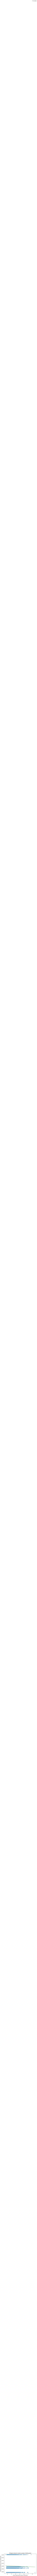

In [140]:
plt.figure(figsize=(8,5))
plt.scatter(valid_y, preds, alpha=0.6)
plt.plot(np.unique(valid_y), np.poly1d(np.polyfit(valid_y, preds, 1))(np.unique(valid_y)), color='g')
#plt.plot(x_lin, x_lin + 0, linestyle='solid', color='red')
plt.text(8,4.5, 'r^2=0.64', size=12)
plt.xlabel('Actual Log Emissions (tonne CO2/month)')
plt.ylabel('Predicted Log Emissions (tonne CO2/month)')
plt.title('Philippine Results (random sample of 5000 points)')